In [14]:
import sys
import os
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import shutil
from glob import glob

cwd = os.getcwd()
pardir = os.path.abspath(os.path.join(cwd, ".."))
modeldir = os.path.abspath(os.path.join(pardir, "models"))

if pardir not in sys.path:
    sys.path.append(pardir)

from jDAS import JDAS

# Visualisation parameters (will be reused)
imshow_kwargs = {
    "interpolation": "none",
    "aspect": "auto",
    "vmin": -0.5,
    "vmax": 0.5,
    "rasterized":True
}

## Load Synthetic model

In [2]:
# pretrained synthetic model taken from:
# https://figshare.com/articles/software/A_Self-Supervised_Deep_Learning_Approach_for_Blind_Denoising_and_Waveform_Coherence_Enhancement_in_Distributed_Acoustic_Sensing_data/14152277
pretrained_synthetic_path = '../models/pretrained-paper/pretrained_synthetic.h5'
jdas = JDAS()
model = jdas.load_model(pretrained_synthetic_path)

## Load Santorini Data

In [4]:
# DATASET: 2048
file_path = "../../jDAS-Thesis/data/santorini-DAS-2048-v2"
files = glob(os.path.join(file_path, '*.npy'))
len(files)
test_indices = [3,13,16]
val_files = [files[i] for i in test_indices]
train_files = [i for i in files if i not in val_files]

print(f"{len(train_files)} train and {len(val_files)} val files.")

train_data_ = []
for file in train_files:
    data = np.load(file)
    N_t = data.shape[1]
    t_slice = slice(N_t//4, 3*N_t//4)
    scaled_data = np.zeros_like(data)
    # Loop over data and normalise
    for i, wv in enumerate(data):
        scaled_data[i] = wv / wv[t_slice].std()
    train_data_.append(scaled_data)
train_data_ = np.stack(train_data_)

val_data_ = []
for file in val_files:
    data = np.load(file)
    N_t = data.shape[1]
    t_slice = slice(N_t//4, 3*N_t//4)
    scaled_data = np.zeros_like(data)
    # Loop over data and normalise
    for i, wv in enumerate(data):
        scaled_data[i] = wv / wv[t_slice].std()
    val_data_.append(scaled_data)
val_data_ = np.stack(val_data_)

14 train and 3 val files.


In [5]:
# Reshape as the model needs multiples of 2048 to split into 2048 pieces
train_data = train_data_.reshape((14,500,2*2048))
val_data = val_data_.reshape((3,500,2*2048))

In [6]:
batch_size = 32
batch_multiplier = 10
jdas = JDAS()
model = jdas.load_model()

train_loader = jdas.init_dataloader(train_data, batch_size, batch_multiplier)
val_loader = jdas.init_dataloader(val_data, batch_size, batch_multiplier)

(32, 11, 2048, 1) (32, 11, 2048, 1) (32, 11, 2048, 1)


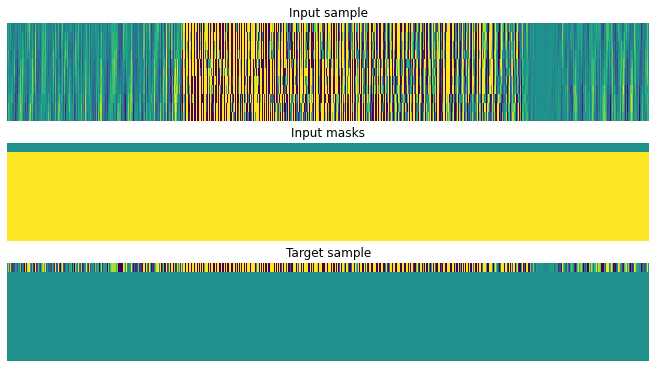

In [7]:
n = 0

(sample, mask), masked_sample = train_loader.__getitem__(0)

print(sample.shape, mask.shape, masked_sample.shape)

plt.close("all")
fig, axes = plt.subplots(nrows=3, figsize=(9, 5), constrained_layout=True, sharex="all", sharey="all")
axes[0].imshow(sample[n, :, :, 0] / sample[n].std(), **imshow_kwargs)
axes[0].set_title("Input sample")
axes[1].imshow(mask[n, :, :, 0] / mask[n].std(), **imshow_kwargs)
axes[1].set_title("Input masks")
axes[2].imshow(masked_sample[n, :, :, 0] / masked_sample[n].std(), **imshow_kwargs)
axes[2].set_title("Target sample")

for ax in axes:
    ax.axis("off")
    
plt.show()

In [8]:
""" Callbacks """

model_name = "Santorini-DAS-2048"

logdir = os.path.join("logs", model_name)
if os.path.isdir(logdir):
    shutil.rmtree(logdir)
    
savefile = "saved-model-santorini.h5"
savedir = os.path.join("save", model_name)
if not os.path.isdir(savedir):
    os.makedirs(savedir)

tensorboard_callback = jdas.callback_tensorboard(logdir)
checkpoint_callback = jdas.callback_checkpoint(os.path.join(savedir, savefile))

In [9]:
model.fit(
    x=train_loader, validation_data=val_loader,
    callbacks=[tensorboard_callback, checkpoint_callback],
    epochs=50, verbose=1, batch_size=batch_size
)
print("Done")

Epoch 1/50
198/198 [==============================] - 21s 70ms/step - loss: 0.0165 - val_loss: 0.0224
Epoch 2/50
198/198 [==============================] - 13s 64ms/step - loss: 0.0148 - val_loss: 0.0212
Epoch 3/50
198/198 [==============================] - 13s 65ms/step - loss: 0.0147 - val_loss: 0.0217
Epoch 4/50
198/198 [==============================] - 14s 69ms/step - loss: 0.0143 - val_loss: 0.0206
Epoch 5/50
198/198 [==============================] - 14s 72ms/step - loss: 0.0143 - val_loss: 0.0214
Epoch 6/50
198/198 [==============================] - 15s 75ms/step - loss: 0.0143 - val_loss: 0.0212
Epoch 7/50
198/198 [==============================] - 15s 78ms/step - loss: 0.0144 - val_loss: 0.0212
Epoch 8/50
198/198 [==============================] - 17s 85ms/step - loss: 0.0142 - val_loss: 0.0214
Epoch 9/50
198/198 [==============================] - 16s 81ms/step - loss: 0.0141 - val_loss: 0.0201
Epoch 10/50
198/198 [==============================] - 16s 83ms/step - loss: 0.013

In [20]:
event = 2
file_to_denoise = val_data_[event]

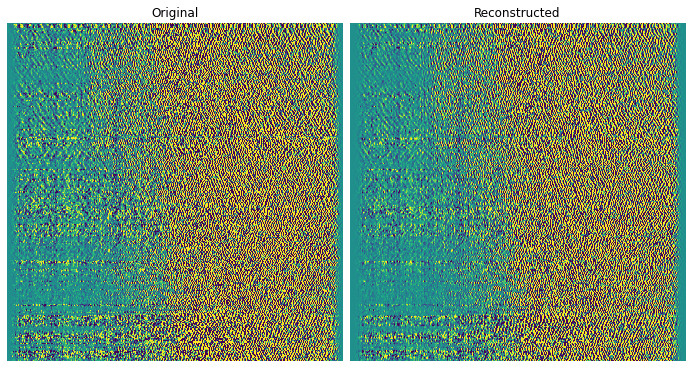

In [21]:
recos = jdas.denoise(file_to_denoise,postfilter = True, filter_band=(1, 10, 45.5))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9.5, 5), constrained_layout=True, sharex="all", sharey="all")

axes = axes.ravel()

axes[0].imshow(file_to_denoise, **imshow_kwargs)
axes[0].set_title("Original")

axes[1].imshow(recos, **imshow_kwargs)
axes[1].set_title("Reconstructed")

for ax in axes:
    ax.axis("off")

plt.show()

(0.0, 41.0)

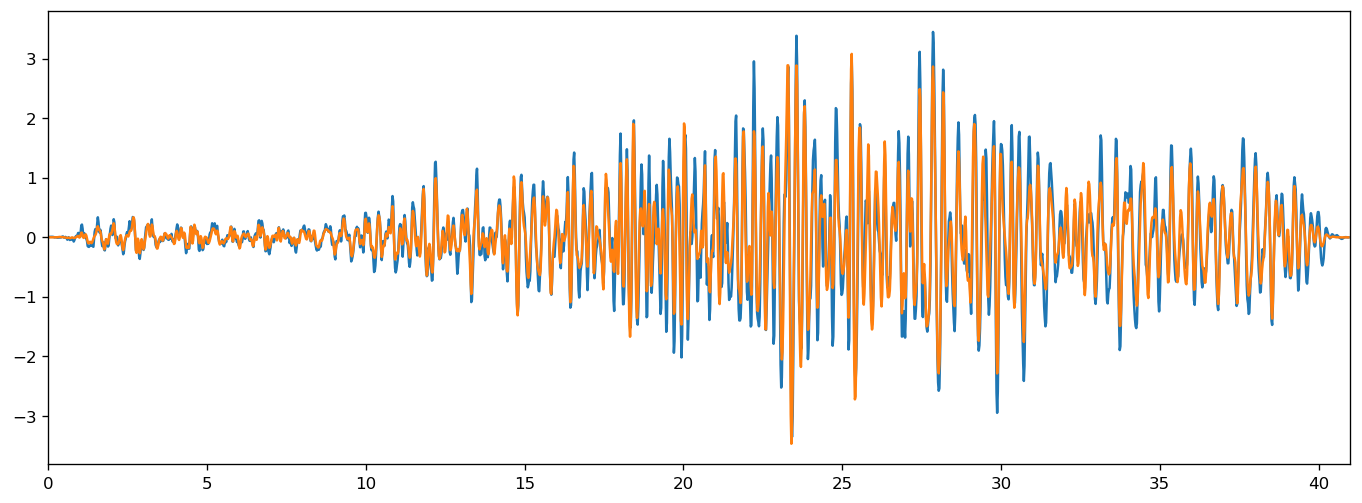

In [22]:
samp = 50.
tmin = 0
tcor = 25
tmax = 41
Nt = file_to_denoise.shape[1]
t = np.arange(Nt) / samp
channel = 0

start = np.argmin(np.abs(t-tcor))
end = np.argmin(np.abs(t-tmax))
t_slice = slice(start, end)
plt.figure(dpi=120,figsize=(14,5))
plt.plot(t,file_to_denoise[channel],label='Original')
plt.plot(t,recos[channel],label='Reconstruction')
plt.xlim((tmin, tmax))